In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')
import numpy as np
import pandas as pd

import yfinance as yf
from hurst import compute_Hc
import seaborn as sns

import ta
import warnings
from tqdm import tqdm

In [50]:
def RSI(val,neutral, window):
  """
        ------------------------------------------------------------------------------
        | Output: The function gives the returns of RSI strategy                     |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Entry values of the stock            |
        |         -neutral (float): Value of neutrality, i.e. no action zone         |
        |         -window (float): rolling period for RSI                            |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("We need have a columns name Adj Close because all computation are about this column")

  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()



  """ Long buy Signal """
  # We put threshold
  overbuy = 70
  neutral_buy = 50 + neutral

  # Put nan values for the signal long columns
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
  val.loc[(val["rsi"]<overbuy)&(val["yersteday_rsi"]>overbuy), "signal_long"] = 0



  """Short sell signal """
  # We put threshold
  oversell = 30
  neutral_buy = 50 - neutral

  # Put nan values for the signal short columns
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Short signal (RSI yersteday>45 and RSI today<45)
  val.loc[(val["rsi"]<neutral_buy) & (val["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

  # We need define the Close Short signal (RSI yersteday<45 and RSI today>45) False signal
  val.loc[(val["rsi"]>neutral_buy)&(val["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

  # We need define the Close Short signal (RSI yersteday<30 and RSI today>30) Over sell signal
  val.loc[(val["rsi"]>oversell)&(val["yersteday_rsi"]<oversell), "signal_short"] = 0


  """ Compute the returns """
  # Compute the percentage of variation of the asset
  val["pct"] = val["Adj Close"].pct_change(1)

  # Compute the positions
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Compute the return of the strategy
  val["return"] = val["pct"]*(val["Position"].shift(1))
  return val["return"]

In [14]:
data = yf.download('GOOG')

[*********************100%***********************]  1 of 1 completed


In [51]:
RSI(data['2010'],5,14).dropna()

45


C:\Users\ksmur\AppData\Local\Temp/ipykernel_15348/261229309.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  RSI(data['2010'],5,14).dropna()
C:\Users\ksmur\AppData\Local\Temp/ipykernel_15348/4211405084.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()
C:\Users\ksmur\AppData\Local\Temp/ipykernel_15348/4211405084.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Date
2010-03-05    0.017346
2010-03-08   -0.003066
2010-03-09   -0.004071
2010-03-10    0.029026
2010-03-11    0.008136
                ...   
2010-12-27   -0.003062
2010-12-28   -0.005744
2010-12-29    0.003473
2010-12-30   -0.003561
2010-12-31   -0.000000
Name: return, Length: 210, dtype: float64

In [19]:
def beta_function(serie):

  # Get SP500 data
  sp500 = yf.download("^GSPC")[["Adj Close"]].pct_change(1)

  # Change column name
  sp500.columns = ["SP500"]

  # Concatenate
  g = pd.concat((serie,sp500), axis=1)

  # Compute the beta
  beta = np.cov(g[[serie.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(g["SP500"].dropna().values)
  return beta

In [20]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1
  return drawdown

In [40]:
def BackTest(serie):

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  print(sp500.head(),serie.dropna().head())
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie)

  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))

  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum(), color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum(), color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])

  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()




  # Compute the sortino
  sortino = np.sqrt(252) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  # beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)
  beta = beta_function(serie)
  print(serie)
  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")

In [48]:
RSI(data,10,3).dropna()

Date
2004-08-31   -0.003529
2004-09-01    0.020709
2004-09-02   -0.012569
2004-09-03   -0.000000
2004-09-07    0.000000
                ...   
2022-01-03   -0.002730
2022-01-04   -0.000000
2022-01-05   -0.000000
2022-01-06   -0.000000
2022-01-07   -0.000000
Name: return, Length: 4371, dtype: float64

[*********************100%***********************]  1 of 1 completed
Date
1950-01-03         NaN
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
Name: Adj Close, dtype: float64 Date
2004-08-31   -0.003529
2004-09-01    0.020709
2004-09-02   -0.012569
2004-09-03   -0.000000
2004-09-07    0.000000
Name: return, dtype: float64


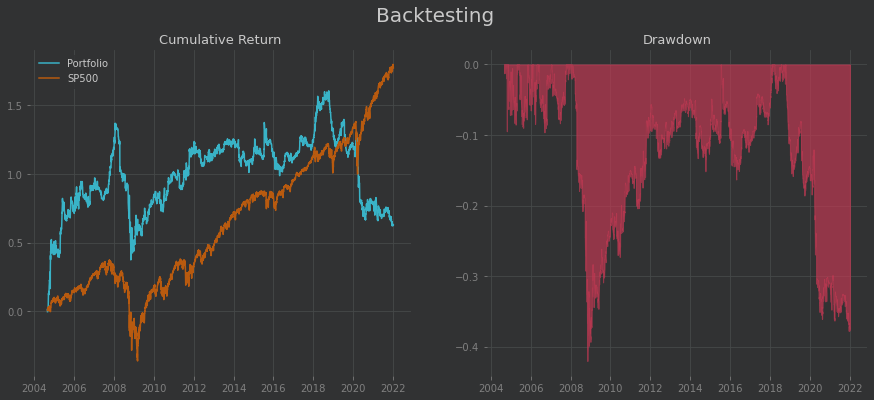

[*********************100%***********************]  1 of 1 completed
Date
2004-08-19        NaN
2004-08-20        NaN
2004-08-23        NaN
2004-08-24        NaN
2004-08-25        NaN
               ...   
2022-01-03   -0.00273
2022-01-04   -0.00000
2022-01-05   -0.00000
2022-01-06   -0.00000
2022-01-07   -0.00000
Name: return, Length: 4379, dtype: float64
Sortino: 0.148
Beta: -0.318
Alpha: 0.048
MaxDrawdown: 42.03 %


In [49]:
BackTest(RSI(data,10,3))